In [1]:
%pylab inline
import numpy as np
import irm
import seaborn as sns

from irm import cvpipelineutil
import sklearn.metrics


Populating the interactive namespace from numpy and matplotlib


# synthetic data, no distance-dependence

In [2]:
true_classes = ['gradstudent', 'postdoc', 'faculty', 'vendor']

tries_talk_probs = {}
MAXDIST = 100
tries_talk_probs[('gradstudent', 'gradstudent')] =  (MAXDIST, 0.05)
tries_talk_probs[('gradstudent', 'postdoc')] = (MAXDIST, 0.5) 
tries_talk_probs[('gradstudent', 'faculty')] = (MAXDIST, 0.8) 

tries_talk_probs[('postdoc', 'postdoc')] = (MAXDIST, 0.8)
tries_talk_probs[('postdoc', 'faculty')] = (MAXDIST, 0.7)

tries_talk_probs[('faculty', 'faculty')] = (MAXDIST, 0.9)

tries_talk_probs[('vendor', 'gradstudent')] =  (MAXDIST, 0.2)
tries_talk_probs[('vendor', 'postdoc')] = (MAXDIST, 0.2) 
tries_talk_probs[('vendor', 'faculty')] = (MAXDIST, 0.7) 
tries_talk_probs[('vendor', 'vendor')] = (MAXDIST, 0.1)

# turn into numeric types
ttp_numeric = {}
for k, v in tries_talk_probs.iteritems():
    ttp_numeric[(true_classes.index(k[0]), true_classes.index(k[1]))] = v
    

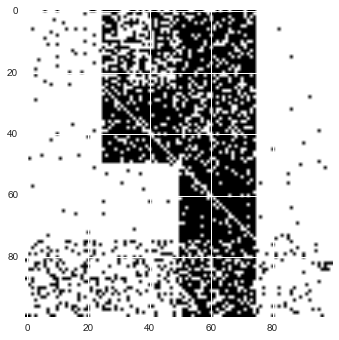

In [3]:
np.random.seed(0)
nodes, conmat = irm.data.generate.c_class_neighbors(5, ttp_numeric, JITTER=0.1)
np.fill_diagonal(conmat, 0) # don't try and talk to yourself
#randomize the order 
ca = np.random.permutation(len(nodes))
conmat_true = conmat.copy()
nodes = nodes[ca]
conmat = conmat[ca]
conmat = conmat[:, ca]


pylab.imshow(conmat_true)

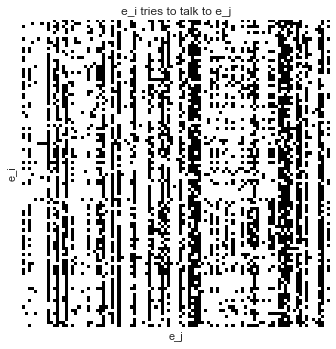

In [4]:
pylab.imshow(conmat, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')
pylab.title("e_i tries to talk to e_j")
pylab.xticks([])
pylab.yticks([])
pylab.savefig("nodist.data.png")

In [5]:
# inference? 


conmat = conmat.astype(np.uint8)

model_name = "BetaBernoulliNonConj"
init, data = irm.irmio.default_graph_init(conmat, model_name)
init['domains']['d1']['assignment'] = np.random.permutation(len(conmat)) % 100

HPS = {'alpha' : 1.0, 'beta' : 1.0}

init['relations']['R1']['hps'] = HPS
slow_anneal = irm.runner.default_kernel_anneal(iterations=20)

kc ={'ITERS' : 50, 
    'kernels' : slow_anneal}

s = cvpipelineutil.run_exp_pure(data, init, 'anneal_slow_10', 0, kc)


Creating threadpool with 8 cores
FIXED_K= False
Running with relation_class= <class 'irm.pyirmutil.ParRelation'>
This model fixed_k=  False
Annealing at temp= 32.0
kernels: nonconj_gibbs 0.54 sec
kernels: slice_params 0.03 sec
kernels: domain_hp_grid 0.01 sec
kernels: relation_hp_grid 0.02 sec
kernels: anneal 0.60 sec
Iter 1
Annealing at temp= 26.6643842048
kernels: nonconj_gibbs 0.27 sec
kernels: slice_params 0.01 sec
kernels: domain_hp_grid 0.01 sec
kernels: relation_hp_grid 0.01 sec
kernels: anneal 0.31 sec
Iter 2
Annealing at temp= 22.2184182818
kernels: nonconj_gibbs 0.23 sec
kernels: slice_params 0.01 sec
kernels: domain_hp_grid 0.01 sec
kernels: relation_hp_grid 0.01 sec
kernels: anneal 0.26 sec
Iter 3
Annealing at temp= 18.5137637965
kernels: nonconj_gibbs 0.42 sec
kernels: slice_params 0.01 sec
kernels: domain_hp_grid 0.01 sec
kernels: relation_hp_grid 0.01 sec
kernels: anneal 0.44 sec
Iter 4
Annealing at temp= 15.4268159671
kernels: nonconj_gibbs 0.35 sec
kernels: slice_param

In [6]:
res = s['res']
scores, state, times, _ = res

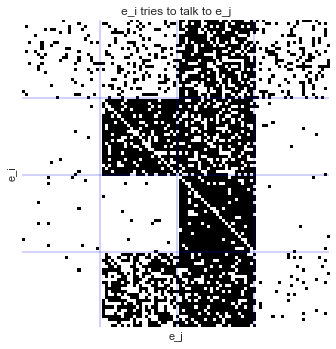

In [7]:
a = irm.util.canonicalize_assignment(state['domains']['d1']['assignment'])
ca = np.argsort(a).flatten()
conmat_sorted = conmat[ca]
conmat_sorted = conmat_sorted[:, ca]
pylab.imshow(conmat_sorted, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')
pylab.title("e_i tries to talk to e_j")
pos = np.argwhere(np.diff(a[ca]))
for p in pos:
    pylab.axhline(p, c='b', alpha=0.2)
    pylab.axvline(p, c='b', alpha=0.2)
pylab.xticks([])
pylab.yticks([])
pylab.savefig("nodist.recovered.png")

In [8]:
sklearn.metrics.confusion_matrix(nodes['class'], a)


array([[ 1,  0,  0, 24],
       [ 0, 25,  0,  0],
       [ 0,  0, 25,  0],
       [25,  0,  0,  0]])

# synthetic data, distance-dependence

In [9]:
true_classes = ['gradstudent', 'postdoc', 'faculty', 'vendor']

tries_talk_probs = {}
MAXDIST = 100


tries_talk_probs[('gradstudent', 'gradstudent')] =  (1.0, 0.2)
tries_talk_probs[('gradstudent', 'postdoc')] = (1.5, 0.5) 
tries_talk_probs[('gradstudent', 'faculty')] = (3.0, 0.8)  # grad students really willing to seek out facutly

tries_talk_probs[('postdoc', 'postdoc')] = (1.5, 0.8)
tries_talk_probs[('postdoc', 'faculty')] = (2.0, 0.7)

tries_talk_probs[('faculty', 'faculty')] = (1.0, 0.9) # faculty will talk to nearby faculty 

tries_talk_probs[('vendor', 'gradstudent')] =  (1.0, 0.2)
tries_talk_probs[('vendor', 'postdoc')] = (1.0, 0.2) 
tries_talk_probs[('vendor', 'faculty')] = (2.0, 0.7) 
tries_talk_probs[('vendor', 'vendor')] = (0.5, 0.1)


# turn into numeric types
ttp_numeric = {}
for k, v in tries_talk_probs.iteritems():
    ttp_numeric[(true_classes.index(k[0]), true_classes.index(k[1]))] = v
    



In [10]:
np.random.seed(1)

nodes, conmat = irm.data.generate.c_class_neighbors(10, ttp_numeric, JITTER=0.1)
np.fill_diagonal(conmat, 0) # don't try and talk to yourself
#randomize the order 
ca = np.random.permutation(len(nodes))
nodes = nodes[ca]
conmat = conmat[ca]
conmat = conmat[:, ca]

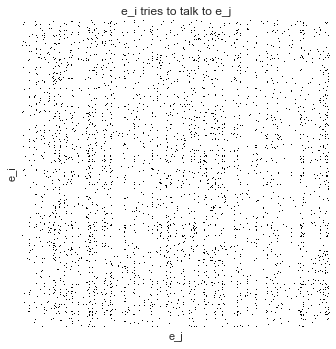

In [11]:
dist_conmat = conmat.copy()
pylab.imshow(dist_conmat, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')

pylab.xticks([])
pylab.yticks([])
pylab.title("e_i tries to talk to e_j")
pylab.savefig("dist.data.png")

### Inference with no distance dependence

In [12]:
conmat = conmat.astype(np.uint8)

model_name = "BetaBernoulliNonConj"
init, data = irm.irmio.default_graph_init(conmat, model_name)
init['domains']['d1']['assignment'] = np.random.permutation(len(conmat))  % 100
\
HPS = {'alpha' : 1.0, 'beta' : 1.0}

init['relations']['R1']['hps'] = HPS
slow_anneal = irm.runner.default_kernel_anneal(iterations=10)

kc ={'ITERS' : 30, 
    'kernels' : slow_anneal}

s = cvpipelineutil.run_exp_pure(data, init, 'anneal_slow_10', 0, kc)
res = s['res']
scores, state, times, _ = res

Creating threadpool with 8 cores
FIXED_K= False
Running with relation_class= <class 'irm.pyirmutil.ParRelation'>
This model fixed_k=  False
Annealing at temp= 32.0
kernels: nonconj_gibbs 3.22 sec
kernels: slice_params 0.06 sec
kernels: domain_hp_grid 0.04 sec
kernels: relation_hp_grid 0.03 sec
kernels: anneal 3.36 sec
Iter 1
Annealing at temp= 21.7726400028
kernels: nonconj_gibbs 0.85 sec
kernels: slice_params 0.04 sec
kernels: domain_hp_grid 0.04 sec
kernels: relation_hp_grid 0.02 sec
kernels: anneal 0.94 sec
Iter 2
Annealing at temp= 14.8139953966
kernels: nonconj_gibbs 1.30 sec
kernels: slice_params 0.05 sec
kernels: domain_hp_grid 0.05 sec
kernels: relation_hp_grid 0.02 sec
kernels: anneal 1.43 sec
Iter 3
Annealing at temp= 10.0793683992
kernels: nonconj_gibbs 1.08 sec
kernels: slice_params 0.02 sec
kernels: domain_hp_grid 0.03 sec
kernels: relation_hp_grid 0.02 sec
kernels: anneal 1.15 sec
Iter 4
Annealing at temp= 6.85795186282
kernels: nonconj_gibbs 0.90 sec
kernels: slice_param

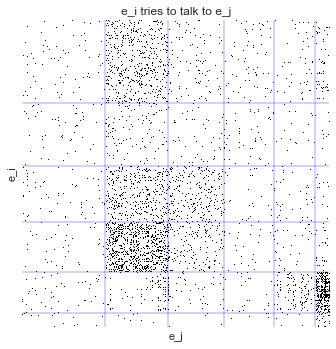

In [13]:
a = irm.util.canonicalize_assignment(state['domains']['d1']['assignment'])
ca = np.argsort(a).flatten()
conmat_sorted = conmat[ca]
conmat_sorted = conmat_sorted[:, ca]
pylab.imshow(conmat_sorted, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')
pos = np.argwhere(np.diff(a[ca]))
for p in pos:
    pylab.axhline(p, c='b', alpha=0.2)
    pylab.axvline(p, c='b', alpha=0.2)
pylab.xticks([])
pylab.yticks([])
pylab.title("e_i tries to talk to e_j")
pylab.savefig("dist.nodistrecover.png")

In [14]:
print np.unique(a) 

[0 1 2 3 4 5]


In [15]:
sklearn.metrics.confusion_matrix(nodes['class'], a)


array([[15,  0,  2, 63, 20,  0],
       [ 9,  0, 69,  0, 22,  0],
       [ 0, 82,  0,  0,  0, 18],
       [85,  0,  2,  2, 11,  0],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0]])

In [16]:
def dist(a, b):
    return np.sqrt(np.sum((b-a)**2))

conn_and_dist = np.zeros(conmat.shape, 
                         dtype=[('link', np.uint8), 
                                ('distance', np.float32)])
print "conn_and_dist.dtype", conn_and_dist.dtype
for ni, foo in enumerate(nodes):
    for nj, bar in enumerate(nodes):
        conn_and_dist[ni, nj]['link'] = conmat[ni, nj]
        conn_and_dist[ni, nj]['distance'] = dist(nodes[ni]['pos'],
                                                 nodes[nj]['pos'])
            

model_name = "LogisticDistance"
init, data = irm.irmio.default_graph_init(conn_and_dist, model_name)
init['domains']['d1']['assignment'] = np.random.permutation(len(conmat))  % 100

mulamb = 1.0
p_max = 0.95

HPS = {'mu_hp' : mulamb,
       'lambda_hp' : mulamb,
       'p_min' : 0.01, 
       'p_max' : p_max}

init['relations']['R1']['hps'] = HPS

slow_anneal = irm.runner.default_kernel_anneal(iterations=10)

kc ={'ITERS' : 30, 
    'kernels' : slow_anneal}

s = cvpipelineutil.run_exp_pure(data, init, 'anneal_slow_10', 0, kc)
res = s['res']
scores, state, times, _ = res

conn_and_dist.dtype [('link', 'u1'), ('distance', '<f4')]
Creating threadpool with 8 cores
FIXED_K= False
Running with relation_class= <class 'irm.pyirmutil.ParRelation'>
This model fixed_k=  False
Annealing at temp= 32.0
kernels: nonconj_gibbs 3.77 sec
kernels: slice_params 0.35 sec
kernels: domain_hp_grid 0.04 sec
kernels: relation_hp_grid 0.22 sec
kernels: anneal 4.39 sec
Iter 1
Annealing at temp= 21.7726400028
kernels: nonconj_gibbs 3.62 sec
kernels: slice_params 0.25 sec
kernels: domain_hp_grid 0.03 sec
kernels: relation_hp_grid 0.23 sec
kernels: anneal 4.12 sec
Iter 2
Annealing at temp= 14.8139953966
kernels: nonconj_gibbs 2.42 sec
kernels: slice_params 0.24 sec
kernels: domain_hp_grid 0.03 sec
kernels: relation_hp_grid 0.22 sec
kernels: anneal 2.91 sec
Iter 3
Annealing at temp= 10.0793683992
kernels: nonconj_gibbs 2.77 sec
kernels: slice_params 0.30 sec
kernels: domain_hp_grid 0.03 sec
kernels: relation_hp_grid 0.23 sec
kernels: anneal 3.33 sec
Iter 4
Annealing at temp= 6.857951

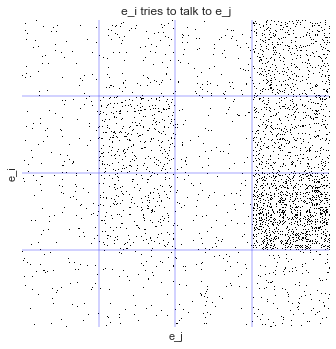

In [17]:
a = irm.util.canonicalize_assignment(state['domains']['d1']['assignment'])
ca = np.argsort(a).flatten()

conmat_sorted = conn_and_dist['link'][ca]
conmat_sorted = conmat_sorted[:, ca]
pylab.imshow(conmat_sorted, interpolation='nearest')
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')

pos = np.argwhere(np.diff(a[ca]))
for p in pos:
    pylab.axhline(p, c='b', alpha=0.2)
    pylab.axvline(p, c='b', alpha=0.2)

pylab.xticks([])
pylab.yticks([])
pylab.title("e_i tries to talk to e_j")
pylab.savefig("dist.distrecover.png")

In [18]:
sklearn.metrics.confusion_matrix(nodes['class'], a)


array([[  0,   0, 100,   0],
       [  0, 100,   0,   0],
       [  0,   0,   0, 100],
       [100,   0,   0,   0]])